### Notebook to plot BOWTIE sounding data.

James Ruppert  
jruppert@ou.edu  
8/19/24

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from thermo_functions import *
import xarray as xr
import pandas as pd
from scipy import stats, signal
from bowtie_read_data import *
from time_series_diag import *
import seaborn as sns

### Read in data

In [26]:
# Soundings
soundings, snd_files, times_snd = read_bowtie_soundings(search_string = 'ascen')
snd_vars = list(soundings.keys())[2:] # retain only 2-d variables in list

# Radiometer data
cwv_rdm, times_rdm = read_bowtie_radiometer()

# Sun photometer data
photom = read_bowtie_sunphotometer()

#### Smooth radiometer data

In [27]:
# Impose running average on CWV from radiometer
# nt_sm = np.timedelta64(120, 'm') # 120-minute rolling average
nt_sm = np.timedelta64(60, 'm') # 120-minute rolling average
dt_rdm = times_rdm[1]-times_rdm[0]
nt_smooth = int(nt_sm/dt_rdm)

cwv_rdm_pd = pd.DataFrame(cwv_rdm)
cwv_rdm_pd = cwv_rdm_pd.interpolate()
# Interpolate across NaNs
cwv_rdm = np.squeeze(cwv_rdm_pd.interpolate())
cwv_rdm_sm = cwv_rdm_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=nt_smooth).mean()
# cwv_rdm_sm = cwv_rdm_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=nt_smooth,
#                                         win_type='cosine').mean()
cwv_rdm_sm = np.squeeze(cwv_rdm_sm)

### Compute diagnostics

In [28]:
# Vertical mass-weighted integral
#   inputs:
#       tmpk:   temperature [K]
#       mr:     water vapor mixing ratio [kg/kg]
#       p:      pressure [Pa]
#       hght:   height [m]
#   options:
#       minpres: set this to minimum pressure to integrate over [Pa]
def vert_integral(invar, tmpk, mr, p, hght, minpres=0):
    rho = density_moist(tmpk, mr, p) # kg/m3
    dz = hght[1]-hght[0] # m
    invar_masked = np.copy(invar)
    invar_masked[np.where(p < minpres)] = np.nan
    var_int = np.nansum(invar_masked*rho, axis=1)*dz
    # for iz in range(len(hght)):
    #     print(snd_asc['p'][15,iz])
    var_int[ np.where(np.isnan(soundings['p'][:,5])) ] = np.nan
    return var_int

In [29]:
# Constants
cp=1004.  # J/K/kg
cpl=4186. # J/k/kg
cpv=1885. # J/K/kg
lv0=2.5e6 # J/kg
g = 9.81 # m/s2
# Latent heat of vaporization
lv = lv0 - (cpl-cpv)*(soundings['tmpk']-273.15)

minpres=50e2 # Upper pressure bound for vertical integrals [Pa]

# MSE
dse = cp*soundings['tmpk'] + g*soundings['hght'][np.newaxis,:]
mse = dse + lv*soundings['mr']
mse_vint = vert_integral(mse, soundings['tmpk'], soundings['mr'], soundings['p'], soundings['hght'], minpres=minpres)

# CWV/PW
# 1/g int(q)dp = s2/m * kg/m/s2 --> kg/m2 --> x1/rho_l --> 10^-3 kg/m2*m3/kg --> 10^-3m = mm
# int<q*rho>dz = kg/m3*m = kg/m2 = mm
cwv = vert_integral(soundings['mr'], soundings['tmpk'], soundings['mr'], soundings['p'],
                    soundings['hght'], minpres=0) # mm or kg/m2
                    # hght, minpres=60000) # mm or kg/m2

#### Mask out soundings that don't reach 100 hPa

In [30]:
# First save minimum pressure
nt = soundings['p'].shape[0]
minpres_tser = np.zeros(nt)
for it in range(nt):
    minpres_tser[it] = np.nanmin(soundings['p'][it]*1e-2) # hPa
# minpres_tser[np.where(minpres > pmax)]=pmax-1

min_pres = np.zeros(nt)
for isnd in range(nt):
    min_pres[isnd] = np.nanmin(soundings['p'][isnd,:]*1e-2) # Pa --> hPa
cwv = np.ma.masked_where((min_pres > 100), cwv, copy=False)
# Apply to all variables in the vertical
# min_pres = np.repeat(min_pres[:,np.newaxis], soundings['hght'].size, axis=1)
# for ivar in snd_vars:
#     soundings[ivar] = np.ma.masked_where((min_pres > 100), soundings[ivar], copy=False)

/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_86310/701472122.py:5: RuntimeWarning: All-NaN slice encountered
  minpres_tser[it] = np.nanmin(soundings['p'][it]*1e-2) # hPa
/var/folders/9x/209ltwrn2b359nrrh4638hv40000gp/T/ipykernel_86310/701472122.py:10: RuntimeWarning: All-NaN slice encountered
  min_pres[isnd] = np.nanmin(soundings['p'][isnd,:]*1e-2) # Pa --> hPa


### Find radiometer bias

In [31]:
# XX Get an array of times in sec for both datasets from some consistent baseline
t_start = np.datetime64('2024-08-17T00')
# t_end = times_rdm.max()
t_end = times_snd.max()
t_ind_snd = np.where((times_snd >= t_start) & (times_snd <= t_end))[0]
# t_ind_rdm = np.where((times_rdm >= t_start) & (times_rdm <= t_end))[0]
# times_asc_sec = (times_snd[t_ind_snd]-t_start)/np.timedelta64(1, 's')
# times_rdm_sec = (times_rdm[t_ind_rdm]-t_start)/np.timedelta64(1, 's')

# First smooth radiometer data to 3-hourly for consistent sampling with soundings
# using running average
nt_sm = np.timedelta64(3*60, 'm') # 3-hr rolling average
dt_rdm = times_rdm[1]-times_rdm[0]
nt_smooth = int(nt_sm/dt_rdm)
cwv_rdm_pd = pd.DataFrame(cwv_rdm)
cwv_rdm_sndsmooth = cwv_rdm_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=nt_smooth).mean()
# cwv_rdm_sndsmooth = cwv_rdm_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=nt_smooth,
#                                         win_type='cosine').mean()
cwv_rdm_sndsmooth = np.squeeze(cwv_rdm_sndsmooth)

# Then interpolate onto sounding times to be able to take difference
# cwv_sndinterp = np.interp(times_asc_sec, times_rdm_sec, cwv_rdm_sm[t_ind_rdm])
cwv_sndinterp = np.interp((times_snd[t_ind_snd].astype('datetime64[ns]')).astype(np.float64),
                       (times_rdm.astype('datetime64[ns]')).astype(np.float64), cwv_rdm_sndsmooth)

bias = np.nanmean(cwv[t_ind_snd]) - np.nanmean(cwv_sndinterp)
print('Bias:', bias, 'mm')

Bias: 3.8866263602764946 mm


---
### Plotting routines

#### Plotting functions

In [70]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})
# sns.set_theme(style="dark")

In [71]:
def smooth_var(invar, time):
    # Impose running average to smooth input variable
    nt_sm = np.timedelta64(6, 'h') # x-minute rolling average
    dt_invar = time[1]-time[0]
    nt_smooth = int(nt_sm/dt_invar)

    invar_pd = pd.DataFrame(invar)
    # invar_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=nt_smooth).mean()
    invar_sm = invar_pd.rolling(window=nt_smooth, center=True, closed='both', min_periods=nt_smooth,
                                          win_type='cosine').mean()
    return np.squeeze(invar_sm)

In [72]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    # Use lag-1 autocorrelation to estimate N
    def acf(x, length=20):
        return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
            for i in range(1, length)])
    ac = acf(a,length=2)[1]
    n = len(a)
    n *= (1-ac)/(1+ac)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

In [73]:
def plot_time_series(figdata, scatter=True, axline=False):
    fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

    ax.set_title(figdata['title'])
    ax.set_ylabel(figdata['ylabel'])
    ax.set_xlabel('Date')

    sizes=20

    finite=np.where(np.isfinite(figdata['pltvar']))
    ax.plot(figdata['time'][finite], figdata['pltvar'][finite], color='black', zorder=1)#, linewidth=1.0)
    if scatter:
        ax.scatter(figdata['time'], figdata['pltvar'], s=sizes, zorder=2)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    if axline:
        ax.axhline(y=figdata['axline'], color='red', linewidth=0.8, zorder=0)

    plt.show()
    plt.close()
    return

In [74]:
def plot_cwv_comparison(plt, ax, figdata, axline=False):

    ax.set_xlabel('Date')
    ax.set_title('IWV Comparison')
    ax.set_ylabel('kg m$^{-2}$ or mm')

    t_max=np.max((figdata['time1'][-1],figdata['time2'][-1],figdata['time3'].iloc[-1]))
    ax.set_xlim((figdata['time1'][0],t_max))
    # ax.set_xlim((figdata['time1'][-8],t_max))

    # color1='#ff7f50'#'red'
    color1='red'
    color2='black'
    color3='#00008B'

    linewidth=1

    # First plot
    sizes=20
    # finite=np.where(np.isfinite(figdata['pltvar1']))
    # ax.plot(figdata['time1'][finite], figdata['pltvar1'][finite], color=color1, zorder=1,
    #         label=figdata['label1'], linewidth=linewidth)
    ax.scatter(figdata['time1'], figdata['pltvar1'], label=figdata['label1'], s=sizes, zorder=1, c=color1, alpha=0.5)
    # mean1, h1 = mean_confidence_interval(figdata['pltvar1'][finite])

    if 'pltvar2' in figdata:
        ax.plot(figdata['time2'], figdata['pltvar2'], color=color2, zorder=2, alpha=0.6,
                label=figdata['label2'], linewidth=linewidth*.75)
        # ax.plot(figdata['time2'], figdata['pltvar2v2'], color=color2, linestyle='--', zorder=2, alpha=0.6,
        #         label=figdata['label2'], linewidth=linewidth*.75)
        # mean2, h2 = mean_confidence_interval(figdata['pltvar2'])
    if 'pltvar3' in figdata:
        sizes=np.full(len(figdata['time3']), 20)
        ax.scatter(figdata['time3'], figdata['pltvar3'], s=sizes, zorder=3, c=color3, alpha=0.5,
                label=figdata['label3'])
        # mean3, h3 = mean_confidence_interval(figdata['pltvar3'])
    # if 'pltvar4' in figdata:
    #     ax.plot(figdata['time4'], figdata['pltvar4'], '-.k', zorder=3,
    #             label=figdata['label3'], linewidth=linewidth)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    # xloc=figdata['time1'][2]
    # tdelt=np.timedelta64(3, 'h')
    # linewidth=2.5
    # ax.vlines(xloc,         ymin=mean1-h1, ymax=mean1+h1, color=color1, linewidth=linewidth)
    # ax.vlines(xloc+tdelt*2, ymin=mean2-h2, ymax=mean2+h2, color=color2, linewidth=linewidth)
    # ax.vlines(xloc+tdelt*3, ymin=mean3-h3, ymax=mean3+h3, color=color3, linewidth=linewidth)
    # ax.plot(xloc,         mean1, marker='o', color='black', markersize=2)
    # ax.plot(xloc+tdelt*2, mean2, marker='o', color='black', markersize=2)
    # ax.plot(xloc+tdelt*3, mean3, marker='o', color='black', markersize=2)

    if axline:
        ax.axhline(y=figdata['axline'], color='black', linestyle='--', linewidth=0.8, zorder=0)

    plt.legend(loc='lower right')
    return

In [75]:
def plot_time_series_comp(figdata, axline=False):

    fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

    plot_cwv_comparison(plt, ax, figdata, axline=axline)

    plt.show()
    plt.close()
    return

In [76]:
def plot_time_height_subpanel(figdata, do_smooth=False, cwv=None, do_log=False, top=18):

    fig_x = 9
    # fig_y = 3.5
    # fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column
    fig_y = 7
    fig, axs = plt.subplots(2, 1, figsize=(fig_x,fig_y), height_ratios=[.5,.5], layout='constrained',squeeze=True)

    # axs[0].set_title(figdata['fig_title'])
    axs[0].set_title('Sounding Relative Humidity (wrt Ice)')

    axs[0].set_ylabel('Height [km]')
    axs[0].set_ylim(0,top)

    t_max=np.max((figdata['time1'][-1],figdata['time2'][-1],figdata['time3'].iloc[-1]))
    xlim=(figdata['time1'][0],t_max)
    axs[0].set_xlim(xlim)
    # axs[0].set_xlabel('Date')

    axs[0].grid(True, axis='x', color='0.55', linewidth=0.5, zorder=4)
    axs[0].grid(True, axis='y', color='0.55', linewidth=0.5, zorder=4)#, which='both')

    # Plot variable
    xdim=figdata['time1']
    pltvar = figdata['pltvar0']
    if do_smooth:
        pltvar = smooth_var(pltvar)

    # norm=colors.Normalize(np.min(figdata['clevels']), np.max(figdata['clevels']))
    # im = ax.pcolormesh(np.repeat(xdim[:,np.newaxis],len(hght),axis=1), np.repeat(hght[np.newaxis,:]*1e-3,len(xdim),axis=0), pltvar, cmap=figdata['cmap'], shading='gouraud', norm=norm)#figdata['norm'])
    im = axs[0].contourf(xdim, soundings['hght']*1e-3, pltvar.transpose(), figdata['clevels'],
                    extend=figdata['extend'], cmap=figdata['cmap'], zorder=0)#, norm=figdata['norm'])
    fig.colorbar(im, ax=axs[0], label=figdata['units'], ticks=ticker.AutoLocator())#, shrink=0.6)

    # Line contours
    # im = axs[0].contour(xdim, hght*1e-3, pltvar.transpose(), figdata['clevels_line'],
    #                 colors=figdata['clevels_line_color'],linewidths=0.6, zorder=2)

    linewidth=1

    # Time labels
    axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
    axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

    # Hide labels
    axs[0].xaxis.set_ticklabels([])

    ##################################################

    # CWV SUBPANEL
    plot_cwv_comparison(plt, axs[1], figdata, axline=True)

    plt.show()
    plt.close()
    return

#### Minimum sounding pressure

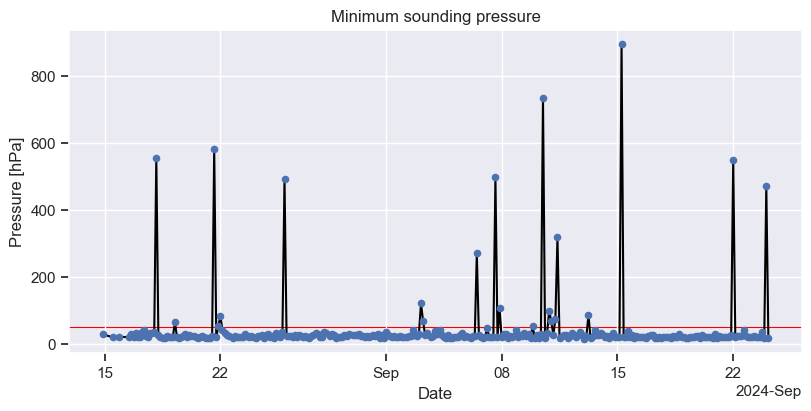

In [77]:
figdata={
    'pltvar': minpres_tser,
    'time': times_snd,
    'title': 'Minimum sounding pressure',
    'ylabel': 'Pressure [hPa]',
    'axline': 50,
    }

plot_time_series(figdata, axline=True)

#### Integrated water vapor (IWV) AKA Precipitable water (PW)

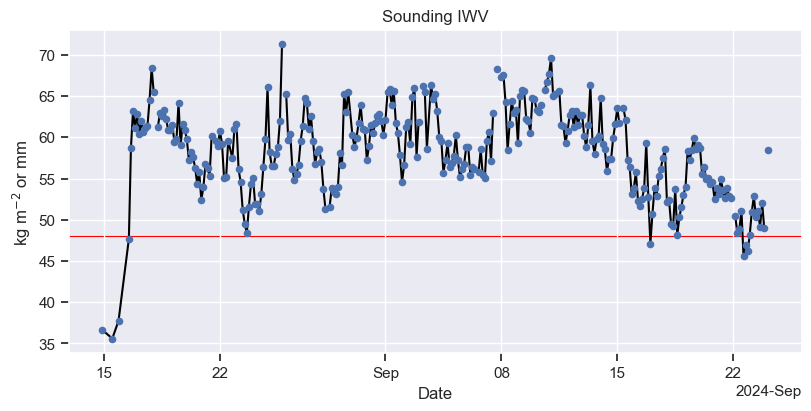

In [78]:
figdata={
    'pltvar': cwv,
    'time': times_snd,
    'title': 'Sounding IWV',
    'ylabel': 'kg m$^{-2}$ or mm',
    'axline': 48,
    }

plot_time_series(figdata, axline=True)

#### Data set comparison

In [79]:
# figdata={
#     'pltvar1': cwv,
#     'pltvar2': cwv_rdm_sm+bias,
#     # 'pltvar2': cwv_rdm+bias,
#     # 'pltvar2': cwv_rdm,
#     # 'pltvar2': cwv_rdm_sm,
#     'pltvar3': photom['Water Vapor(cm)'],
#     'time1': times_snd,
#     'time2': times_rdm,
#     'time3': photom['Date(dd:mm:yyyy)'],
#     'label1': 'Soundings',
#     'label2': 'Radiometer (+'+str(np.round(bias,decimals=2))+' mm)',
#     # 'label2': 'Radiometer',
#     'label3': 'Microtops (post-processed from web)',
#     'axline': 48,
#     }

# plot_time_series_comp(figdata, axline=True)

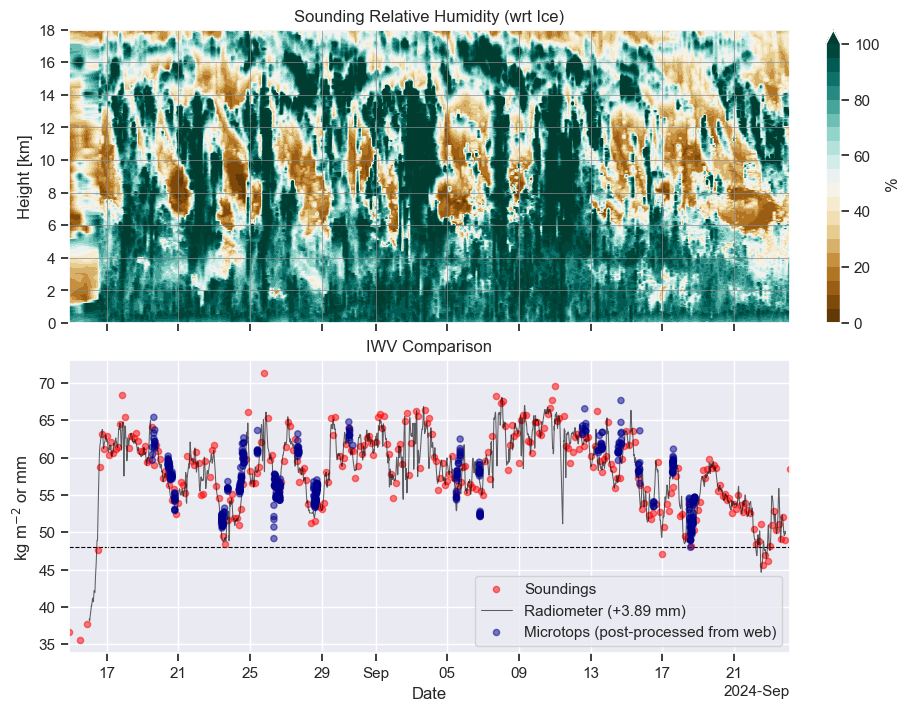

In [80]:
# RH with subpanel

cint_lines = 20
contours = np.arange(cint_lines,cint_lines*10,cint_lines)

relh = calc_relh(soundings['mr'], soundings['p'], soundings['tmpk'], ice=True)
relh_df = pd.DataFrame(relh)
relh_df = relh_df.interpolate()
relh = np.squeeze(relh_df)
# relh_smooth = smooth_var(relh, times_snd)

figdata={
    'pltvar0': relh,#relh_smooth,
    'clevels': np.arange(0,105,5),
    'clevels_line': contours,
    'clevels_line_color': 'black',
    'cmap': 'BrBG',
    'extend': 'max',
    'units': '%',
    'pltvar1': cwv,
    'pltvar2': cwv_rdm_sm+bias,
    # 'pltvar2v2': cwv_rdm_sm,
    # 'pltvar2': iwv_rdm_sm,
    'pltvar3': photom['Water Vapor(cm)'],
    'time1': times_snd,
    'time2': times_rdm,
    'time3': photom['Date(dd:mm:yyyy)'],
    'label1': 'Soundings',
    'label2': 'Radiometer (+'+str(np.round(bias,decimals=2))+' mm)',
    # 'label2': 'Radiometer',
    'label3': 'Microtops (post-processed from web)',
    'title': 'IWV Comparison',
    'ylabel': 'kg m$^{-2}$ or mm',
    'axline': 48,
    }

plot_time_height_subpanel(figdata)

In [81]:
# # Print sounding CWV

# for itim in range(cwv.size):
#     print(times_snd[itim], cwv[itim])

#### CAPE/CIN

In [82]:
cape_sfc, cin_sfc = get_cape_cin(soundings['tmpk'], soundings['mr'], soundings['p'], type = 'sfc')
cape_mu, cin_mu = get_cape_cin(soundings['tmpk'], soundings['mr'], soundings['p'], type = 'mu')
# cape, cin = get_cape_cin(soundings['tmpk'][0:25], soundings['mr'][0:25], soundings['p'][0:25])

In [83]:
# Time series function

def plot_time_series_capecin(figdata):
    fig, ax = plt.subplots(figsize=(8,4), layout="constrained")

    ax.set_title(figdata['title'])
    ax.set_ylabel(figdata['ylabel'])
    ax.set_xlabel('Date')

    linewidth=1.0
    color1='red'
    color2='blue'
    color3='green'
    sizes=20

    finite=np.where(np.isfinite(figdata['cape']))
    ax.plot(figdata['time'][finite], figdata['cape'][finite], color='black', alpha=0.7, zorder=1, linewidth=linewidth)
    ax.scatter(figdata['time'], figdata['cape'], s=sizes, color=color1, zorder=2, alpha=0.7, label=figdata['label1'])
    ax.scatter(figdata['time'], figdata['cape2'], s=sizes, color=color3, zorder=2, alpha=0.5, label=figdata['label2'])

    ax.plot(figdata['time'][finite], figdata['cin'][finite], color='black', alpha=0.7, zorder=1, linewidth=linewidth)
    ax.scatter(figdata['time'], figdata['cin'], s=sizes, color=color2, zorder=2, alpha=0.3, label=figdata['label3'])

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    plt.legend()#loc='lower right')

    # if axline:
        # ax.axhline(y=figdata['axline'], color='red', linewidth=0.8, zorder=0)

    plt.show()
    plt.close()
    return

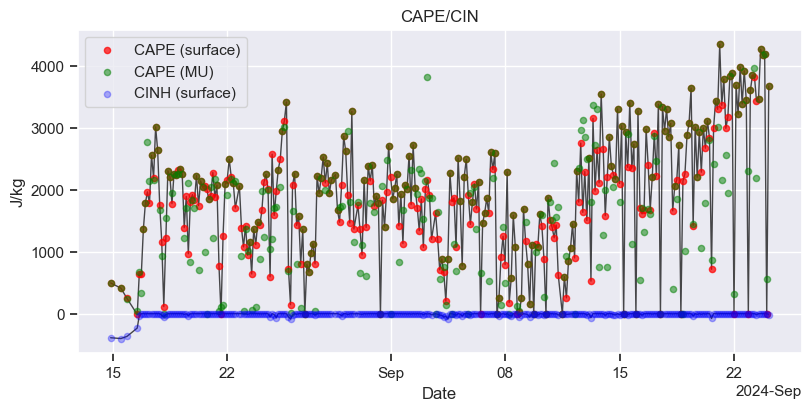

In [84]:
figdata={
    'cape': cape_sfc,
    'cape2': cape_mu,
    'cin': cin_sfc,
    'label1': 'CAPE (surface)',
    'label2': 'CAPE (MU)',
    'label3': 'CINH (surface)',
    'time': times_snd,
    'title': 'CAPE/CIN',
    'ylabel': 'J/kg',
    }

plot_time_series_capecin(figdata)

### Diurnal composites

#### Functions

In [85]:
# def plot_dc(figdata):

#     npd=figdata['npd']
#     var_dc = diurnal_composite(figdata['pltvar'], npd, anom=figdata['anom'])

#     fig_x = 6
#     fig_y = 3.5
#     fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

#     ax.set_title(figdata['fig_title'])

#     ax.set_ylabel('Height [km]')
#     ax.set_ylim(0,16)#12)
#     # ax.set_ylim(10,22)#12)
#     ax.set_xlim(0,48)

#     ax.grid(True, axis='x', color='0.55', linewidth=0.5)
#     ax.grid(True, axis='y', color='0.55', linewidth=0.5)#, which='both')

#     # Plot variable
#     # xdim=np.arange(npd+1)*24/npd
#     xdim=np.arange(npd*2+1)*24/npd
#     # im = axs[iax].pcolormesh(xdim, hght, pltvar, cmap=figdata['cmap'], norm=figdata['norm'])
#     im = ax.contourf(xdim, soundings['hght']*1e-3, var_dc.transpose(), figdata['clevels'],
#                     extend=figdata['extend'], cmap=figdata['cmap'])#, norm=figdata['norm'])
#     fig.colorbar(im, ax=ax, label=figdata['units'])#, shrink=0.6)

#     # Line contours
#     im = ax.contour(xdim, soundings['hght']*1e-3, var_dc.transpose(), figdata['clevels_line'],
#                     colors=figdata['clevels_line_color'],linewidths=0.6)

#     ax.axvline(x=24, color='black')

#     # Time labels
#     ax.set_xlabel('Hour [UTC]')

#     plt.show()
#     plt.close()
#     return

In [86]:
def plot_diurnal_composite(figdata):

    def dc_smooth(invar, nt_smooth=10):
        # Copy ends to make smoothing periodic
        invar_long = np.concatenate((invar[-nt_smooth:], invar, invar[:nt_smooth]))
        invar_df = pd.DataFrame(invar_long)
        invar_smoothed = invar_df.rolling(window=nt_smooth, center=True, closed='both', min_periods=int(nt_smooth/2),
                                          win_type='cosine').mean()
        return np.squeeze(invar_smoothed[nt_smooth:-nt_smooth])

    fig_x = 8
    fig_y = 3.5
    fig, ax = plt.subplots(figsize=(fig_x,fig_y), layout="constrained",) # row, column

    ax.set_title(figdata['fig_title'])

    ax.set_xlabel('Hour [UTC]')
    plt.xticks(np.arange(0,49,6))

    xdim = np.arange(figdata['npd']*2+1)*24/figdata['npd']

    linewidth=1.
    alpha=1.
    color1='#ff7f50'
    # color2='#2ca02c'
    color2='#1f77b4'
    color3='black'
    sizes=20

    ax.set_ylabel(figdata['units1'])
    nt_smooth = 30 # minutes
    ax.plot(xdim, figdata['pltvar1'], linewidth=linewidth, color=color1, label=figdata['label1'], alpha=alpha)
    ax.scatter(xdim, figdata['pltvar1'], s=sizes, color=color1, zorder=2, alpha=0.7)
    # ax.plot(xdim, figdata['pltvar2'], linewidth=linewidth, color=color2, label=figdata['label2'], alpha=alpha)
    ax.plot(xdim, figdata['pltvar2']*np.nan, linewidth=linewidth, color=color2, label=figdata['label2'], alpha=0.4)
    # ax.scatter(xdim, figdata['pltvar2']*np.nan, s=sizes, color=color2, zorder=2, alpha=0.7, label=figdata['label2'])
    # ax.plot(xdim, figdata['pltvar3']*np.nan, linewidth=linewidth, color=color3, label=figdata['label3'], alpha=0.4)

    ax.grid(True, axis='x')
    ax.grid(True, axis='y')

    # Plot vertical line at new day
    ax.axvline(x=24, color='black', alpha=0.6)

    plt.legend()

    # Second axis

    ax2 = ax.twinx()
    ax2.set_ylabel(figdata['units2'])
    ax2.plot(xdim, figdata['pltvar2'], linewidth=linewidth, color=color2, label=figdata['label2'], alpha=0.4)
    ax2.scatter(xdim, figdata['pltvar2'], s=sizes, color=color2, zorder=2, alpha=0.7, label=figdata['label2'])
    # ax2.plot(xdim, figdata['pltvar3'], linewidth=linewidth, color=color3, label=figdata['label3'], alpha=0.4)

    ax2.grid(False, axis='x')
    ax2.grid(False, axis='y')

    plt.show()
    plt.close()
    return

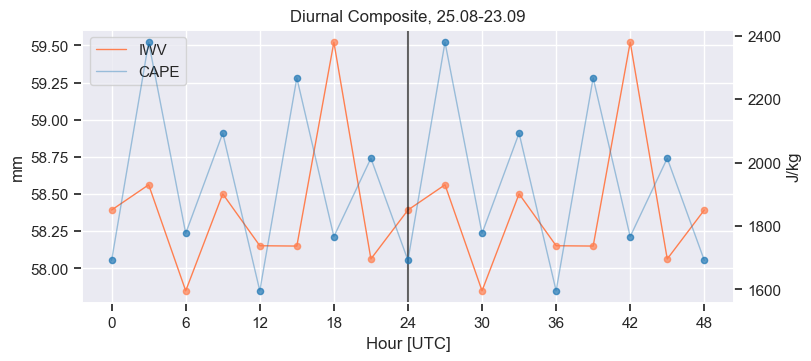

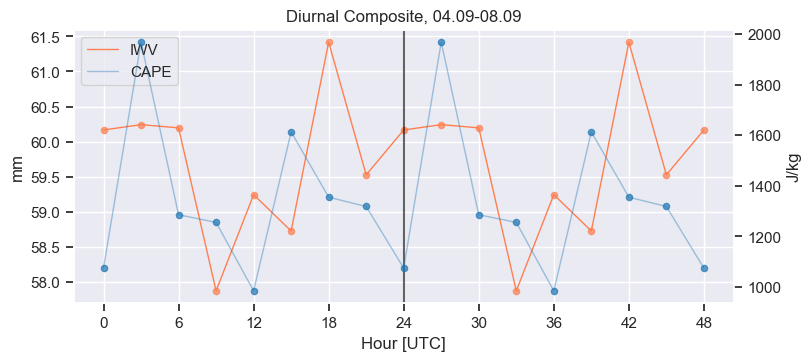

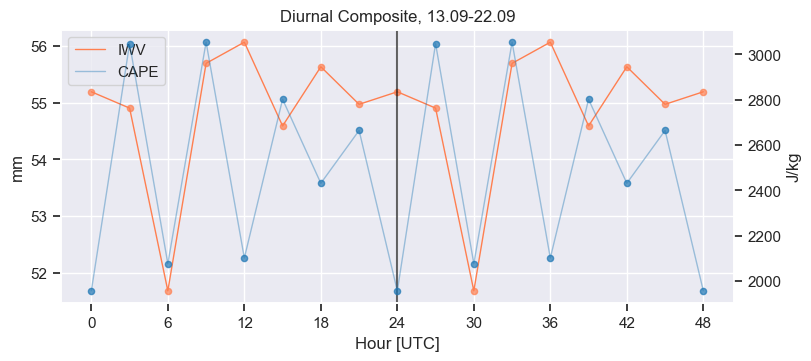

In [91]:
def run_plot():

    dt = np.timedelta64(3, 'h')
    h24 = np.timedelta64(24, 'h').astype('timedelta64[ns]')
    npd = int(np.round(h24 / dt))

    days = np.arange(t0, t1+h24, h24, dtype='datetime64[ns]')
    t0str = np.datetime_as_string(t0)
    t1str = np.datetime_as_string(t1)
    date_str = t0str[8:10]+'.'+t0str[5:7]+'-'+t1str[8:10]+'.'+t1str[5:7]

    figdata = {
        'fig_title': 'Diurnal Composite, '+date_str,
        'pltvar1': diurnal_composite(cwv, times_snd, dt, days=days, anom=anom),
        'pltvar2': diurnal_composite(cape_sfc, times_snd, dt, days=days, anom=anom),
        # 'pltvar3': diurnal_composite(dship['wspd'], dship['time'], dt, days=days, anom=anom),
        'units1': 'mm',
        'units2': 'J/kg',
        'units3': 'm/s',
        'label1': 'IWV',
        'label2': 'CAPE',
        'label3': 'Wind speed',
        'npd': npd,
        }
    plot_diurnal_composite(figdata)
    return

anom=False
# anom=True

t0 = np.datetime64('2024-08-25T00:00')
t1 = np.datetime64('2024-09-23T00:00')

run_plot()

t0 = np.datetime64('2024-09-04T00:00')
t1 = np.datetime64('2024-09-08T00:00')

run_plot()

# t0 = np.datetime64('2024-09-01T00:00')
t0 = np.datetime64('2024-09-13T00:00')
t1 = np.datetime64('2024-09-22T00:00')
# t0 = np.datetime64('2024-09-04T00:00')
# t1 = np.datetime64('2024-09-08T00:00')
# t0 = np.datetime64('2024-09-18T00:00')
# t1 = np.datetime64('2024-09-22T00:00')

run_plot()